# **Random Forest**

In [1]:
import pandas as pd

dataset_work = pd.read_csv('D:\DataSet\dataset_work_transformed.csv')
x = dataset_work.iloc[:,:-1]
y = dataset_work.iloc[:,-1].values
dataset_work.shape

(6435823, 19)

Dividiendo los datos en conjuntos de entrenamiento y prueba

In [4]:
from sklearn.model_selection import train_test_split

# Cargar el dataset
X = dataset_work.drop(columns=['MOROSIDAD']) 
y = dataset_work['MOROSIDAD']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modelo de Random Forest

Para optimizar su rendimiento, se han seleccionado hiperparámetros mediante un proceso de ajuste previo. El modelo utiliza un conjunto de **100 árboles** en el bosque y selecciona características basándose en la raíz cuadrada del número total de características disponibles para cada división. Se ha limitado la **profundidad máxima** del bosque a 20 niveles para evitar el sobreajuste, junto con valores mínimos de muestras requeridas para dividir un nodo interno y para formar un nodo hoja. Adicionalmente, el modelo utiliza un esquema de muestreo **con reemplazo (bootstrap)**. A continuación, se presenta un resumen de los hiperparámetros seleccionados:

| **Hiperparámetro**     | **Valor Seleccionado** |
|------------------------|------------------------|
| `n_estimators`         | 100                    |
| `max_features`         | sqrt                   |
| `max_depth`            | 20                     |
| `min_samples_split`    | 5                      |
| `min_samples_leaf`     | 4                      |
| `bootstrap`            | True                   |

El proceso incluye las siguientes etapas principales: entrenamiento del modelo con los datos de entrenamiento, evaluación mediante validación cruzada para calcular el AUC-ROC promedio, predicción en un conjunto de prueba, y cálculo de métricas de desempeño como la matriz de confusión, el informe de clasificación, y el AUC-ROC. Finalmente, se mide el tiempo total de ejecución del proceso.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
import time

# Registro del tiempo de inicio
start_time = time.time()

# Configuración del modelo de Random Forest con los hiperparámetros proporcionados
model = RandomForestClassifier(
    n_estimators=100,          # Número de árboles en el bosque
    max_features='sqrt',       # Número máximo de características para considerar en cada división
    max_depth=20,              # Profundidad máxima de los árboles
    min_samples_split=5,       # Mínimo número de muestras requeridas para dividir un nodo
    min_samples_leaf=4,        # Mínimo número de muestras requeridas en un nodo hoja
    bootstrap=True,            # Utilizar muestreo con reemplazo
    random_state=42            # Semilla para reproducibilidad
)

# Ajustar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Evaluación del modelo con validación cruzada (cv=3)
auc_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')

# Promedio de AUC-ROC
auc_mean = auc_scores.mean()
print(f"AUC-ROC promedio en validación cruzada: {auc_mean:.4f}")  # Mostrar con 4 decimales

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Evaluar el rendimiento del modelo
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Calcular el AUC-ROC en el conjunto de prueba
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC en conjunto de prueba: {roc_auc:.4f}")  # Mostrar con 4 decimales

# Medir el tiempo de finalización y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time

# Convertir a minutos y segundos
minutes = elapsed_time // 60
seconds = elapsed_time % 60

print(f"El tiempo total de ejecución fue de {int(minutes)} minutos y {seconds:.4f} segundos.")  # Segundos con 4 decimales

AUC-ROC promedio en validación cruzada: 0.9165

Matriz de Confusión:
[[889836 231003]
 [124133 685775]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83   1120839
           1       0.75      0.85      0.79    809908

    accuracy                           0.82   1930747
   macro avg       0.81      0.82      0.81   1930747
weighted avg       0.82      0.82      0.82   1930747

ROC AUC en conjunto de prueba: 0.9177
El tiempo total de ejecución fue de 60 minutos y 5.9915 segundos.


## **Curva ROC (característica operativa del receptor)**

**Propósito:** Mostrar la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para diferentes umbrales de clasificación.

**Beneficio:** Permite evaluar visualmente la capacidad del modelo para distinguir entre las clases y calcular el AUC-ROC (área bajo la curva).

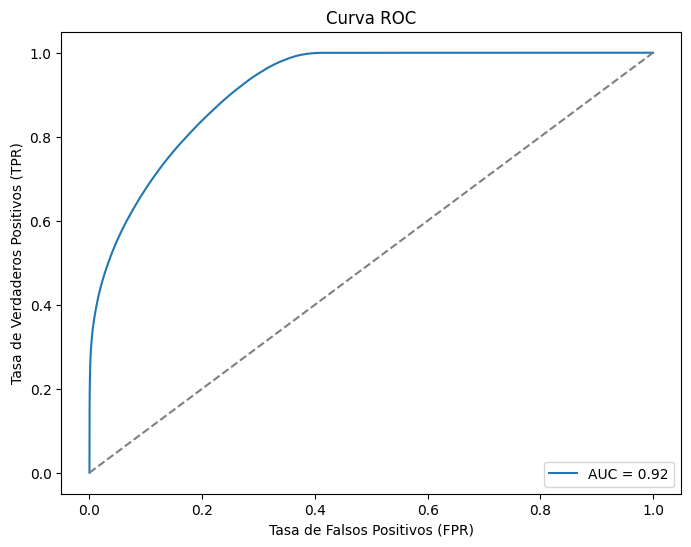

In [6]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()


### Análisis del Gráfico: Curva ROC

El gráfico muestra la curva ROC (Receiver Operating Characteristic) del modelo de Random Forest aplicado a la predicción de la morosidad tributaria. La curva ROC ilustra la relación entre la **Tasa de Verdaderos Positivos (TPR)** y la **Tasa de Falsos Positivos (FPR)** a diferentes umbrales de decisión.

- **Interpretación del AUC:** El área bajo la curva (AUC) es de **0.92**, lo que indica que el modelo tiene un excelente desempeño en la discriminación entre contribuyentes morosos y no morosos. Un AUC cercano a 1 significa que el modelo tiene alta capacidad para diferenciar correctamente entre las dos clases, mientras que un valor de 0.5 sería equivalente a un modelo que predice al azar.

- **Forma de la curva:** La curva ROC muestra un comportamiento ideal, con un ascenso pronunciado en las primeras etapas, lo que indica que el modelo logra captar la mayoría de los casos positivos (morosos) manteniendo baja la tasa de falsos positivos. Esto es crucial en un contexto de predicción de morosidad tributaria, ya que minimizar los falsos positivos puede evitar acciones indebidas hacia contribuyentes cumplidos.

### Conexión con la predicción de morosidad tributaria:
Este resultado sugiere que el modelo de Random Forest es efectivo para identificar a los contribuyentes con alta probabilidad de caer en morosidad. En aplicaciones prácticas, esto permitiría a las autoridades fiscales priorizar sus esfuerzos de cobro en los casos más probables de incumplimiento, optimizando recursos y reduciendo costos.

Si bien el AUC es alto, sería relevante validar este desempeño con métricas adicionales como la matriz de confusión, las tasas de precisión y exhaustividad, y evaluar cómo se comporta el modelo frente a clases desbalanceadas. Esto garantizaría que el modelo no favorezca excesivamente a la clase mayoritaria (no morosos) en caso de un desequilibrio en los datos.

## **Gráfico de Precisión-Recall (Precision-Recall Curve)**
**Propósito:** Evaluar el desempeño del modelo en términos de precisión y sensibilidad (recall) para diferentes umbrales.

**Beneficio:** Es especialmente útil si las clases están desbalanceadas, ya que pone mayor énfasis en los verdaderos positivos.

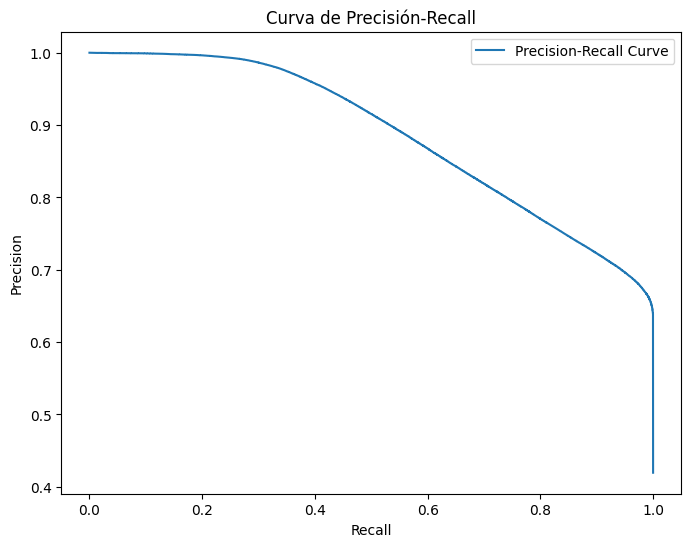

In [11]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva de Precisión-Recall")
plt.legend(loc="upper right")
plt.show()


### Análisis del Gráfico: Curva de Precisión-Recall

El gráfico muestra la relación entre **precisión** y **recall** para el modelo de Random Forest en la predicción de morosidad tributaria. Este tipo de curva es particularmente útil en problemas con clases desbalanceadas, como podría ser el caso de la predicción de morosos (donde la cantidad de contribuyentes no morosos suele ser mucho mayor).

- **Forma de la curva:** La precisión es alta para valores bajos de recall, lo que indica que cuando el modelo predice menos casos positivos (morosos), estos tienden a ser correctos. A medida que aumenta el recall, la precisión disminuye, lo que refleja un incremento en los falsos positivos a medida que se abarcan más casos.

- **Trade-off entre precisión y recall:** En contextos de predicción de morosidad, este gráfico destaca el compromiso entre identificar correctamente la mayor cantidad de morosos (alto recall) y minimizar los falsos positivos (alta precisión). Dependiendo del objetivo de la institución fiscal, podría preferirse un umbral de decisión que favorezca un alto recall (identificar la mayoría de los morosos) incluso a costa de una leve reducción en la precisión.

### Conexión con la predicción de morosidad tributaria:
Este análisis es crítico para ajustar el modelo según las necesidades de la autoridad fiscal. Por ejemplo:
- Si se busca **maximizar la recaudación de deuda** (priorizando identificar a la mayor cantidad de morosos), un umbral que favorezca el recall sería más adecuado.
- Si se quiere **evitar molestias a contribuyentes no morosos**, un enfoque con mayor precisión sería más apropiado.

Finalmente, sería útil calcular el área bajo la curva de precisión-recall (PR AUC) para medir la efectividad global del modelo, especialmente en problemas desbalanceados. Un valor alto indicaría que el modelo gestiona adecuadamente este compromiso.

## **Matriz de Confusión con Mapa de Calor**

**Propósito:** Visualizar la matriz de confusión de forma más interpretativa usando un mapa de calor.

**Beneficio:** Facilitar la identificación de aciertos y errores del modelo en las clases predichas.

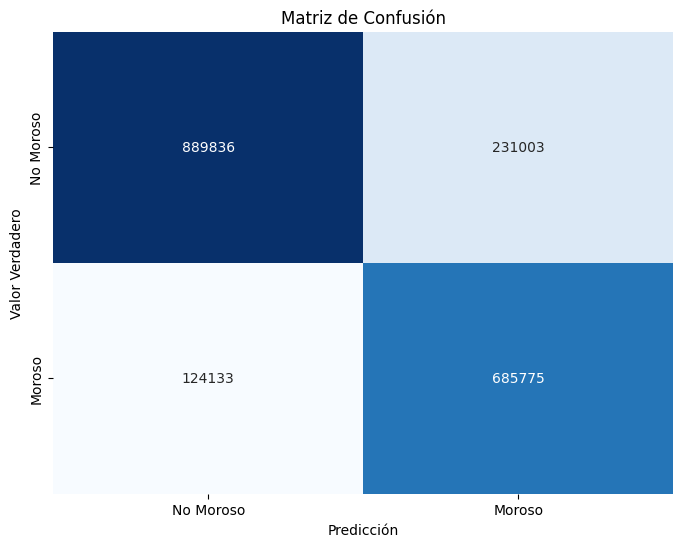

In [12]:
import seaborn as sns
import numpy as np
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Moroso', 'Moroso'], yticklabels=['No Moroso', 'Moroso'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Verdadero")
plt.show()


### Análisis del Gráfico: Matriz de Confusión

La matriz de confusión presentada evalúa el desempeño del modelo de Random Forest en términos de las predicciones de contribuyentes **morosos** y **no morosos**. Este análisis nos permite comprender los aciertos y errores del modelo en ambas clases. 

#### Valores clave:
1. **Verdaderos Negativos (No Moroso correctamente identificado):** 889,836  
2. **Falsos Positivos (No Moroso clasificado como Moroso):** 231,003  
3. **Falsos Negativos (Moroso clasificado como No Moroso):** 124,133  
4. **Verdaderos Positivos (Moroso correctamente identificado):** 685,775  

#### Conexión con la predicción de morosidad tributaria:
El modelo tiene un buen desempeño general, pero existe un número notable de **falsos positivos (231,003)** y **falsos negativos (124,133)**. Esto podría tener implicaciones prácticas:
- Los **falsos positivos** podrían generar acciones innecesarias hacia contribuyentes cumplidos, lo cual debe minimizarse para evitar inconvenientes administrativos o insatisfacción.
- Los **falsos negativos** representan contribuyentes morosos que no fueron identificados, lo que podría resultar en una pérdida de oportunidad para acciones preventivas o recaudatorias.

#### Recomendaciones:
1. **Balance de clases:** Si los datos están desbalanceados (por ejemplo, más "no morosos" que "morosos"), podría ser útil aplicar técnicas como **submuestreo de la clase mayoritaria** o **sobremuestreo de la clase minoritaria** (SMOTE).
2. **Ajuste del umbral de decisión:** Ajustar el umbral de probabilidad podría reducir los falsos negativos o falsos positivos según la prioridad del problema (maximizar recall o precisión).
3. **Evaluación de métricas adicionales:** Complementar este análisis con la métrica F1-Score, que combina precisión y recall, para evaluar el equilibrio global del modelo. 

En conclusión, el modelo tiene un buen desempeño, pero ajustar su salida para reducir los falsos negativos o positivos podría mejorar su efectividad práctica en la predicción de la morosidad tributaria.

## **Importancia de las Características (Coeficientes)**

**Propósito:** Mostrar gráficamente la importancia de las variables en la predicción de la morosidad basada en los coeficientes del modelo de regresión logística.

**Beneficio:** Ayuda a interpretar el modelo ya identificar las variables más influyentes.

C:\Users\hrqui\AppData\Local\Temp\ipykernel_33408\552896770.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Importancia', y='Características', palette='viridis')


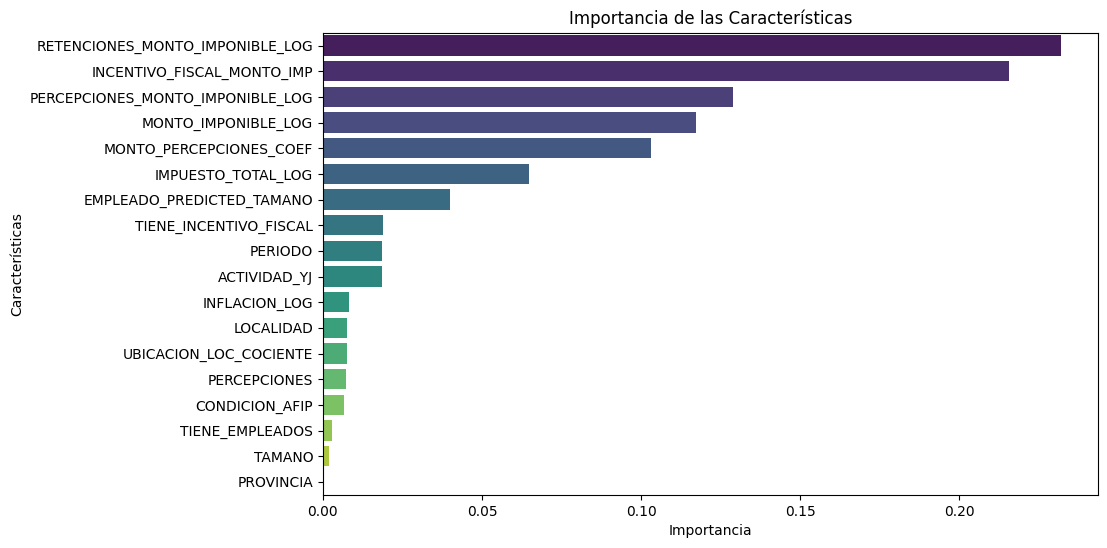

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener la importancia de las características desde el modelo
importances = model.feature_importances_

# Crear un DataFrame con las características y su importancia
coef_df = pd.DataFrame({
    'Características': X_train.columns,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

# Visualización de las importancias
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Importancia', y='Características', palette='viridis')
plt.title("Importancia de las Características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()



### Análisis del Gráfico: Importancia de las Características

Este gráfico muestra la **importancia de las características** utilizadas por el modelo de Random Forest para predecir la morosidad tributaria. La importancia está basada en la capacidad de cada característica para reducir la incertidumbre (medida por la impureza en los nodos) en la clasificación de los casos.

#### Principales observaciones:
1. **Variables más relevantes:**
   - **RETENCIONES_MONTO_IMPONIBLE_LOG:** Es la característica más importante, indicando que las retenciones sobre el monto imponible tienen un papel crucial en determinar la probabilidad de morosidad. Esto sugiere que contribuyentes con mayores valores en esta variable pueden estar más asociados a morosidad o a patrones de incumplimiento.
   - **INCENTIVO_FISCAL_MONTO_IMP:** La magnitud de los incentivos fiscales también es un fuerte predictor. Podría interpretarse que el acceso a incentivos fiscales, dependiendo de su manejo, influye significativamente en el cumplimiento tributario.
   - **PERCEPCIONES_MONTO_IMPONIBLE_LOG y MONTO_IMPONIBLE_LOG:** Estas variables relacionadas con el monto imponible también son muy influyentes, indicando que los valores declarados o percibidos de ingresos impactan directamente en la probabilidad de incumplimiento.

2. **Importancia de otras variables:**
   - **MONTO_PERCEPCIONES_COEF e IMPUESTO_TOTAL_LOG:** Estas variables relacionadas con la estructura fiscal y el monto total de impuestos también tienen un peso relevante en el modelo.
   - **EMPLEADO_PREDICTED_TAMANO:** La predicción del tamaño del negocio o empresa también aporta información clave, lo que podría estar asociado a la capacidad financiera para cumplir obligaciones fiscales.
   - **TIENE_INCENTIVO_FISCAL y PERIODO:** La existencia de incentivos fiscales y el periodo analizado también influyen en menor medida, pero son relevantes.

3. **Variables de menor importancia:**
   - Variables como **PROVINCIA, TAMAÑO, y TIENE_EMPLEADOS** tienen un impacto mucho menor. Esto podría deberse a que no proporcionan información significativa en la clasificación de contribuyentes morosos frente a no morosos.

#### Conexión con la predicción de morosidad tributaria:
El análisis de importancia sugiere que las características relacionadas con los montos económicos y la estructura fiscal tienen un impacto dominante en la predicción de morosidad. Esto es consistente con la lógica fiscal, ya que contribuyentes con altos montos imponibles y retenciones podrían enfrentarse a mayores dificultades de cumplimiento.

#### Recomendaciones:
1. **Validación de las principales variables:** Realizar análisis adicionales (por ejemplo, regresiones univariadas o visualizaciones) para confirmar el impacto de las principales características.
2. **Interpretación práctica:** Las autoridades fiscales podrían focalizar sus esfuerzos en contribuyentes con altos valores de las variables clave identificadas, como las retenciones y montos imponibles.
3. **Exploración de variables menos importantes:** Aunque algunas variables tienen baja importancia, podrían mejorarse mediante transformaciones o combinaciones con otras características para extraer más información útil.

En general, el modelo identifica correctamente las variables más relevantes, permitiendo priorizar estrategias de intervención basadas en estas características clave.

## **Distribución de las Probabilidades**

**Propósito:** Mostrar la distribución de las probabilidades predichas para cada clase.

**Beneficio:** Permite analizar cómo el modelo clasifica los datos y si existe algún solapamiento importante entre las clases.

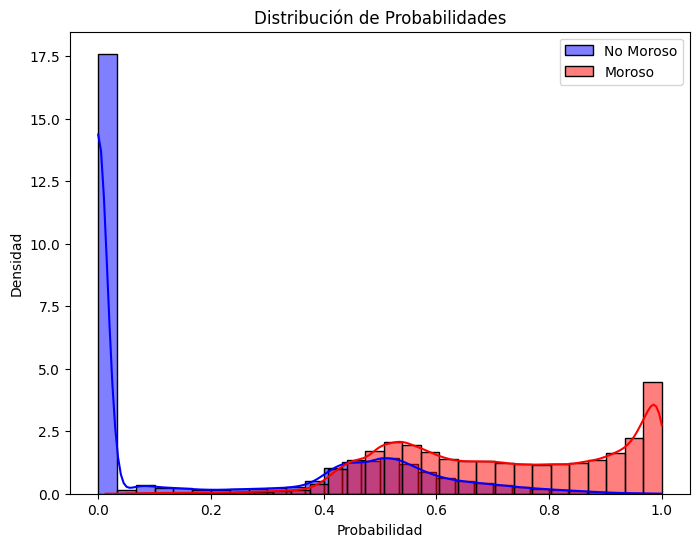

In [15]:
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba[y_test == 0], label='No Moroso', color='blue', kde=True, stat='density', bins=30)
sns.histplot(y_pred_proba[y_test == 1], label='Moroso', color='red', kde=True, stat='density', bins=30)
plt.title("Distribución de Probabilidades")
plt.xlabel("Probabilidad")
plt.ylabel("Densidad")
plt.legend()
plt.show()


### Análisis del Gráfico: Distribución de Probabilidades

El gráfico muestra nuevamente la **distribución de probabilidades** por el modelo para clasificar entre **morosos** y **no morosos**, representadas por las densidades de cada clase. Este tipo de visualización es crucial para evaluar la capacidad del modelo de separar ambas clases con base en las probabilidades asignadas.

#### Observaciones adicionales:
1. **Separación de las clases:**
   - **No morosos (azul):** La mayoría de los casos de no morosos tienen probabilidades predichas cercanas a **0**, lo que indica que el modelo clasifica correctamente una gran proporción de esta clase.
   - **Morosos (rojo):** La mayoría de los casos de morosos tienen probabilidades altas (cercanas a **1**), lo que refleja que el modelo puede capturar patrones específicos de morosidad.

2. **Zona de solapamiento (0.4-0.6):**
   - El rango intermedio sigue siendo el área donde las densidades de ambas clases se superponen. Esta zona representa casos en los que el modelo tiene baja confianza para distinguir entre morosos y no morosos. Aquí es más probable que ocurran **falsos positivos** (no morosos clasificados como morosos) y **falsos negativos** (morosos clasificados como no morosos).

3. **Extremos de la distribución:**
   - Los picos en los extremos (cerca de 0 y 1) indican que el modelo asigna probabilidades con alta confianza para la mayoría de los casos. Este comportamiento es positivo, ya que muestra que el modelo puede discriminar entre las clases en la mayoría de los escenarios.

#### Conexión con la predicción de morosidad tributaria:
Este análisis sigue destacando la utilidad del modelo para priorizar casos de morosidad tributaria. Sin embargo, los casos en la **zona de incertidumbre** (probabilidades entre 0.4 y 0.6) merecen atención especial, ya que podrían representar contribuyentes con comportamiento fiscal irregular o ambiguo.

#### Recomendaciones (ampliadas):
1. **Segmentación y análisis de los casos ambiguos:**
   - Identificar contribuyentes en la zona de solapamiento y realizar un análisis detallado de sus características.
   - Podrían surgir patrones interesantes al segmentar estos casos (por ejemplo, pequeños contribuyentes con montos bajos de impuestos o grandes contribuyentes con comportamientos atípicos).

2. **Optimización del umbral:**  
   - Dependiendo de los objetivos fiscales, ajustar el umbral podría ayudar a mitigar el impacto de falsos negativos (morosos no detectados) o falsos positivos (no morosos clasificados erróneamente).

3. **Refinamiento del modelo:**
   - Investigar si la introducción de nuevas características relacionadas con comportamiento tributario, historial de cumplimiento o características económicas mejora la separación en esta zona intermedia.

En resumen, el modelo demuestra un buen rendimiento general con alta capacidad de separación, aunque los casos ambiguos en el rango de probabilidades intermedias (0.4-0.6) requieren atención para mejorar la confiabilidad del sistema en la práctica tributaria.